In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import random
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_full = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
testset = datasets.MNIST(root = './data', train = False, download = True, transform = transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.10MB/s]


In [4]:
train_data, val_data = torch.utils.data.random_split(trainset_full, [50000, 10000])

valloader = DataLoader(val_data, batch_size = 128, shuffle = False)
testloader = DataLoader(testset, batch_size = 128, shuffle = False)


In [5]:
num_clients = 10

def partition_data_iid(dataset, num_clients):
    client_data = {i: [] for i in range(num_clients)}

    indices = np.random.permutation(len(dataset))
    client_size = len(dataset) // num_clients

    for i in range(num_clients):
        client_indices = indices[i * client_size : (i + 1) * client_size]
        client_data[i] = torch.utils.data.Subset(dataset, client_indices)

    return client_data


def partition_data_non_iid(dataset, num_clients, shards_per_client = 2):
    labels = np.array(dataset.dataset.targets)[dataset.indices]
    indices = np.argsort(labels)
    num_shards = num_clients * shards_per_client
    shard_size = len(dataset) // num_shards

    shards = [indices[i * shard_size:(i + 1) * shard_size] for i in range(num_shards)]
    np.random.shuffle(shards)

    client_data = {}
    for i in range(num_clients):
        assigned_shards = shards[i * shards_per_client:(i + 1) * shards_per_client]
        client_indices = np.concatenate(assigned_shards)
        client_data[i] = torch.utils.data.Subset(dataset, client_indices)

    return client_data


client_train_data_iid = partition_data_iid(train_data, num_clients)
print(f"Data partitioned for {len(client_train_data_iid)} clients.")

client_train_data_non_iid = partition_data_non_iid(train_data, num_clients)
print(f"Data partitioned for {len(client_train_data_non_iid)} clients.")

Data partitioned for 10 clients.
Data partitioned for 10 clients.


In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def federated_averaging(global_model, local_models, local_weights):
    global_dict = global_model.state_dict()

    for key in global_dict.keys():
        global_dict[key] = torch.zeros_like(global_dict[key])

    total_weight = sum(local_weights)

    for (model, weight) in zip(local_models, local_weights):
        for key in global_dict.keys():
            global_dict[key] += model.state_dict()[key] * (weight / total_weight)

    global_model.load_state_dict(global_dict)
    return global_model


def train_local_model(model, train_loader, epochs, learning_rate):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    return model


def plot_confusion_matrix(cm, classes, title = 'Confusion Matrix'):
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)

    plt.figure(figsize = (8, 6))

    sns.heatmap(cm_df, annot = True, cmap = "Blues", fmt = 'g')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def evaluate_model(model, data_loader, class_names, plot_cm = False):
    model.eval()
    model.to(device)

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(targets.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
    precision = precision_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    recall = recall_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)
    f1 = f1_score(true_labels, pred_labels, average = 'weighted', zero_division = 0)

    if plot_cm:
        cm = confusion_matrix(true_labels, pred_labels)
        plot_confusion_matrix(cm, class_names)

    return accuracy, precision, recall, f1

In [8]:
def federated_training(global_model, client_data, valloader, num_rounds, local_epochs, learning_rate, batch_size):
    val_accuracy_history = []
    val_f1_history = []
    class_names = [str(i) for i in range(10)]

    for round_num in range(num_rounds):
        local_models, local_weights = [], []

        selected_clients = list(client_data.keys())

        for client_id in selected_clients:
            client_model = Model().to(device)
            client_model.load_state_dict(global_model.state_dict())

            client_train_loader = DataLoader(client_data[client_id], batch_size = batch_size, shuffle = True)
            trained_model = train_local_model(client_model, client_train_loader, local_epochs, learning_rate)

            local_models.append(trained_model)
            local_weights.append(len(client_data[client_id]))

        global_model = federated_averaging(global_model, local_models, local_weights)

        val_acc, val_prec, val_rec, val_f1 = evaluate_model(global_model, valloader, class_names)
        val_accuracy_history.append(val_acc)
        val_f1_history.append(val_f1)

        print(f"Round {round_num+1}/{num_rounds} | Validation Accuracy: {val_acc*100:.2f}% | Validation F1-Score: {val_f1:.4f}")

    return global_model, val_accuracy_history

In [9]:
NUM_ROUNDS = 5
LOCAL_EPOCHS = 2
LEARNING_RATE = 0.001
BATCH_SIZE = 64

global_model_iid = Model().to(device)
global_model_non_iid = Model().to(device)

print("--- Starting Federated Training on IID distribution ---")
final_model_iid, val_acc_history_iid = federated_training(
    global_model_iid,
    client_train_data_iid,
    valloader,
    num_rounds = NUM_ROUNDS,
    local_epochs = LOCAL_EPOCHS,
    learning_rate = LEARNING_RATE,
    batch_size = BATCH_SIZE
)

print("--- Federated Training Finished ---")

print("--- Starting Federated Training on non-IID distribution ---")
final_model_non_iid, val_acc_history_non_iid = federated_training(
    global_model_non_iid,
    client_train_data_non_iid,
    valloader,
    num_rounds = NUM_ROUNDS,
    local_epochs = LOCAL_EPOCHS,
    learning_rate = LEARNING_RATE,
    batch_size = BATCH_SIZE
)

print("--- Federated Training Finished ---")



--- Starting Federated Training on IID distribution ---
Round 1/5 | Validation Accuracy: 92.92% | Validation F1-Score: 0.9296
Round 2/5 | Validation Accuracy: 97.64% | Validation F1-Score: 0.9764
Round 3/5 | Validation Accuracy: 98.06% | Validation F1-Score: 0.9806
Round 4/5 | Validation Accuracy: 98.36% | Validation F1-Score: 0.9836
Round 5/5 | Validation Accuracy: 98.68% | Validation F1-Score: 0.9868
--- Federated Training Finished ---
--- Starting Federated Training on non-IID distribution ---
Round 1/5 | Validation Accuracy: 49.39% | Validation F1-Score: 0.4249
Round 2/5 | Validation Accuracy: 61.05% | Validation F1-Score: 0.5406
Round 3/5 | Validation Accuracy: 70.34% | Validation F1-Score: 0.6714
Round 4/5 | Validation Accuracy: 76.96% | Validation F1-Score: 0.7431
Round 5/5 | Validation Accuracy: 82.35% | Validation F1-Score: 0.8075
--- Federated Training Finished ---


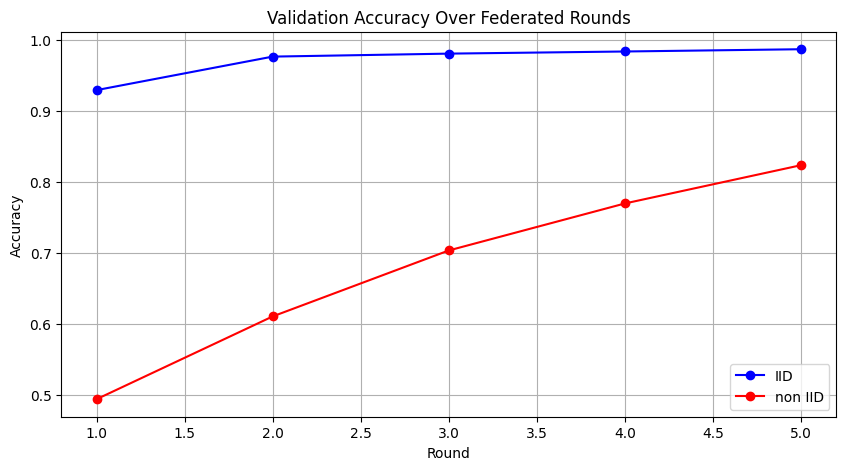


--- Evaluating Final Model on Test Set for IId ---


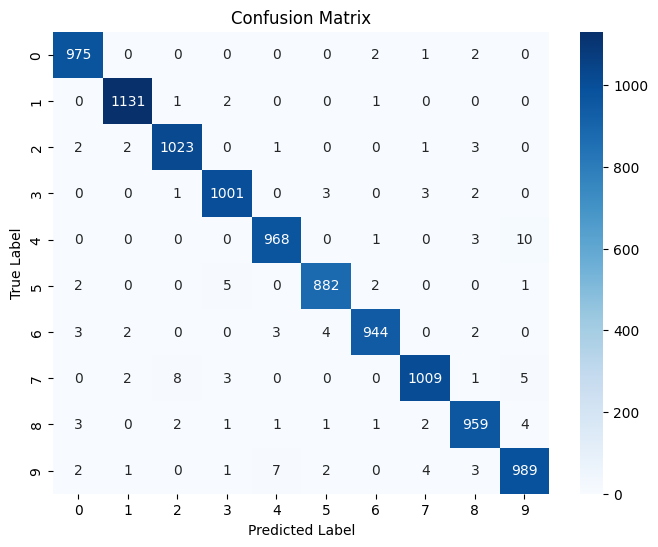

Final Test Accuracy: 98.81%
Final Test Precision: 0.9881
Final Test Recall: 0.9881
Final Test F1-Score: 0.9881

--- Evaluating Final Model on Test Set for non-IId ---


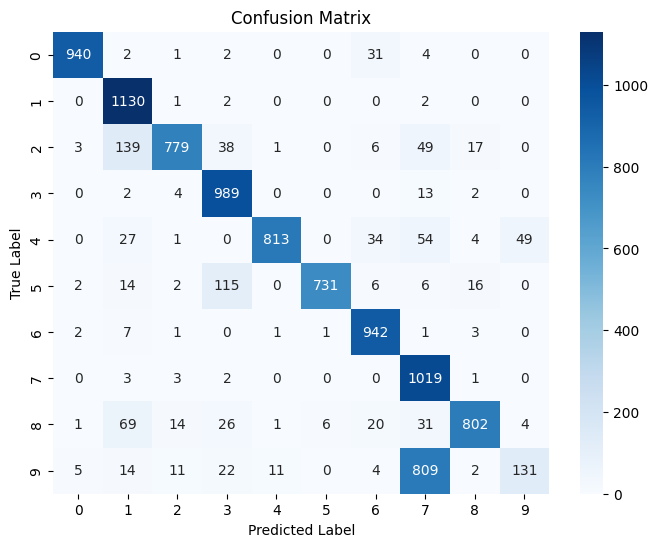

Final Test Accuracy: 82.76%
Final Test Precision: 0.8579
Final Test Recall: 0.8276
Final Test F1-Score: 0.8096


In [10]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_ROUNDS + 1), val_acc_history_iid, marker='o', color='b', label='IID')
plt.plot(range(1, NUM_ROUNDS + 1), val_acc_history_non_iid, marker='o', color='r', label='non IID')
plt.title("Validation Accuracy Over Federated Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


print("\n--- Evaluating Final Model on Test Set for IId ---")
class_names = [str(i) for i in range(10)]
test_acc_iid, test_prec_iid, test_rec_iid, test_f1_iid = evaluate_model(final_model_iid, testloader, class_names, plot_cm=True)

print(f"Final Test Accuracy: {test_acc_iid * 100:.2f}%")
print(f"Final Test Precision: {test_prec_iid:.4f}")
print(f"Final Test Recall: {test_rec_iid:.4f}")
print(f"Final Test F1-Score: {test_f1_iid:.4f}")


print("\n--- Evaluating Final Model on Test Set for non-IId ---")
class_names = [str(i) for i in range(10)]
test_acc_non_iid, test_prec_non_iid, test_rec_non_iid, test_f1_non_iid = evaluate_model(final_model_non_iid, testloader, class_names, plot_cm=True)

print(f"Final Test Accuracy: {test_acc_non_iid * 100:.2f}%")
print(f"Final Test Precision: {test_prec_non_iid:.4f}")
print(f"Final Test Recall: {test_rec_non_iid:.4f}")
print(f"Final Test F1-Score: {test_f1_non_iid:.4f}")